In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmed Mustafa
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class Tweet:
    def __init__(self):
        self.ID = None
        self.content = ''
        self.sentiment = ''

In [3]:
def cleanTweet(tweet):
    # print(tweet.content,"\n")
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove dots/ellipses
    tweet.content = re.sub("@ [a-zA-Z0-9]+", '', tweet.content) # remove @mentions
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet.content) # remove hyperlinks
    tweet.content = re.sub(r'#', '', tweet.content) # remove hastags
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    # print(tweet.content)
    # print("============================================================================")
    return tweet

In [4]:
stopwords_english = stopwords.words('english')
stopwords_hinglish = []
with open('data/hinglish_stopwords.txt','r') as fp:
    while True:
        line = fp.readline()
        if not line:
            break
        stopwords_hinglish.append(line.strip())
stemmer_english = PorterStemmer()

In [5]:
all_tweets = []
with open('data/trial_conll.txt', 'r', encoding="utf8") as fp:
    tweet = Tweet()
    skip = False
    while True:
        line = fp.readline()
        if not line:
            break
        if len(line.split()) > 1:
            if line.split()[0] == 'meta':
                skip = False
                if len(tweet.content) > 0:
                    all_tweets.append(cleanTweet(tweet))
                    tweet = Tweet()
                tweet.ID = line.split()[1]
                tweet.sentiment = line.split()[2]
            elif line.split()[0] == 'http' or line.split()[0] == 'https':
                skip = True
            elif skip == False:
                if line.split()[1] == "Eng":
                    if line.split()[0] not in stopwords_english:
                        tweet.content += stemmer_english.stem(line.split()[0]) + " "
                elif line.split()[1] == "Hin":
                    if line.split()[0] not in stopwords_hinglish:
                        tweet.content += line.split()[0] + " "
                else:
                    tweet.content += line.split()[0] + " "
                  

In [6]:
all_positive_tweets = [i.content for i in all_tweets if i.sentiment=='positive']
all_negative_tweets = [i.content for i in all_tweets if i.sentiment=='negative']
all_neutral_tweets = [i.content for i in all_tweets if i.sentiment=='neutral']
tweets = all_neutral_tweets + all_positive_tweets + all_negative_tweets
labels = np.append(np.zeros(len(all_neutral_tweets)), np.ones(len(all_positive_tweets)))
labels = np.append(labels, np.full(len(all_negative_tweets),2))
print(labels.shape)
print("Number of tweets: ", len(tweets))

(1866,)
Number of tweets:  1866


In [7]:
freqs = dict()
for i in all_tweets:
    for word in i.content.split():
        pair = (word, i.sentiment)
        freqs[pair] = freqs.get(pair, 0) + 1

In [8]:
top_10 = list(sorted(freqs.items(), key=lambda x: x[1],reverse=True))[:10]
for i in top_10:
    print(i)

(('ji', 'positive'), 81)
(('ji', 'neutral'), 74)
(('i', 'positive'), 72)
(('sir', 'positive'), 66)
(('i', 'neutral'), 63)
(('love', 'positive'), 60)
(('h', 'negative'), 58)
(('h', 'neutral'), 58)
(('😂', 'neutral'), 58)
(('modi', 'neutral'), 55)


In [9]:
X = np.empty((0,4))
for i in tweets:
    neutral_words_freq = 0
    positive_words_freq = 0
    negative_words_freq = 0
    for word in i.split():
        neutral_words_freq += freqs.get((word,'neutral'),0)
        positive_words_freq += freqs.get((word,'positive'),0)
        negative_words_freq += freqs.get((word,'negative'),0)
    X = np.append(X, np.array([[1, neutral_words_freq, positive_words_freq, negative_words_freq]]), axis=0)
Y = labels

Text(0, 0.5, 'Negative')

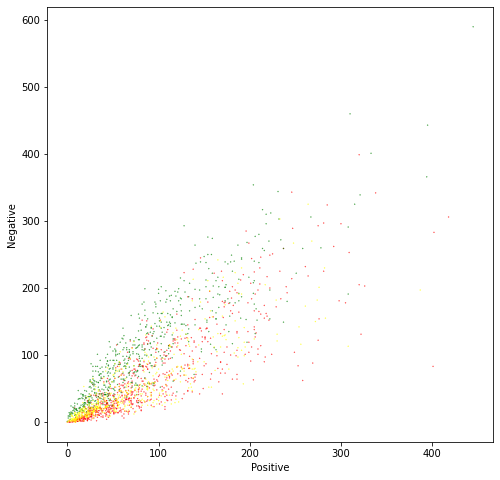

In [10]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green', 'yellow']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

In [11]:
dataset = pd.DataFrame(columns=['Bias','Neutral Freq','Positive Freq','Negative Freq','Class'])
for i in range(len(X)):
    dataset = dataset.append({
        'Bias': X[i][0],
        'Neutral Freq': X[i][1],
        'Positive Freq': X[i][2],
        'Negative Freq': X[i][3],
        'Class': Y[i],
    },ignore_index = True)

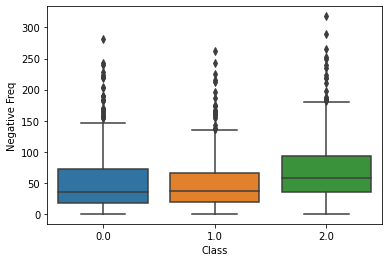

In [12]:
sns.boxplot(x="Class",y="Negative Freq",data=dataset)
plt.show()

<AxesSubplot:xlabel='Neutral Freq', ylabel='Negative Freq'>

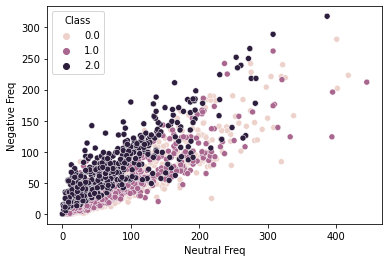

In [13]:
sns.scatterplot(x='Neutral Freq', y='Negative Freq', hue="Class", data=dataset)

In [14]:
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [16]:
y_pred=clf.predict(X_test)


In [17]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(y_test, y_pred, labels=[0,1,2])
cnf_matrix

array([[118,  20,  16],
       [ 23,  77,  13],
       [ 25,  13,  69]], dtype=int64)

In [18]:
def plot_confusion_matrix(cm,title='Confusion Matrix',
                          cmap=plt.cm.Greens):
   
    import itertools
    
    print('Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['1','2','3']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion Matrix


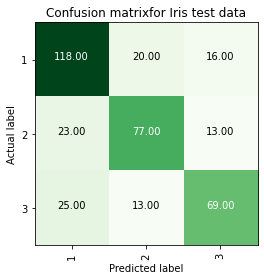

In [19]:
plt.figure()
plot_confusion_matrix(cnf_matrix,title='Confusion matrixfor Iris test data')

In [20]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average="macro"))

0.700417897116191
